In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K

#### Download data

In [2]:
# download dataset from https://drive.google.com/file/d/1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H/view?usp=sharing
!gdown --id 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output brain-mri-seg.zip

Downloading...
From: https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H
To: /content/brain-mri-seg.zip
130MB [00:00, 170MB/s]


In [3]:
# unzip file
!unzip -q brain-mri-seg.zip

#### Data Analysis

In [4]:
# read img and mask
mask_paths = glob('brain-mri-seg/train/*_mask.tif')
mask_path = np.random.choice(mask_paths, size=1)[0]
img_path = mask_path.replace('_mask', '')

print('img_path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

img_path:  brain-mri-seg/train/TCGA_HT_8113_19930809_19.tif
mask path: brain-mri-seg/train/TCGA_HT_8113_19930809_19_mask.tif


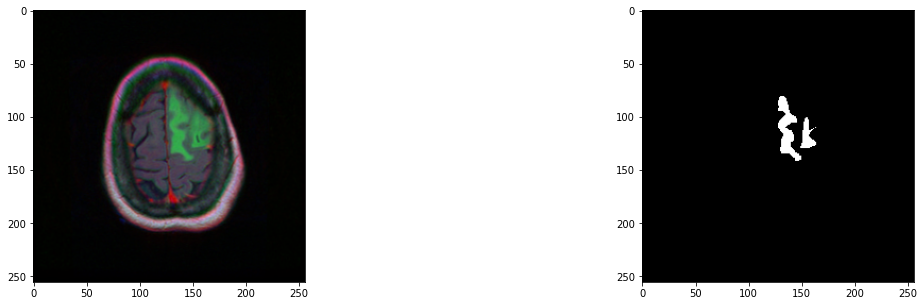

In [5]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

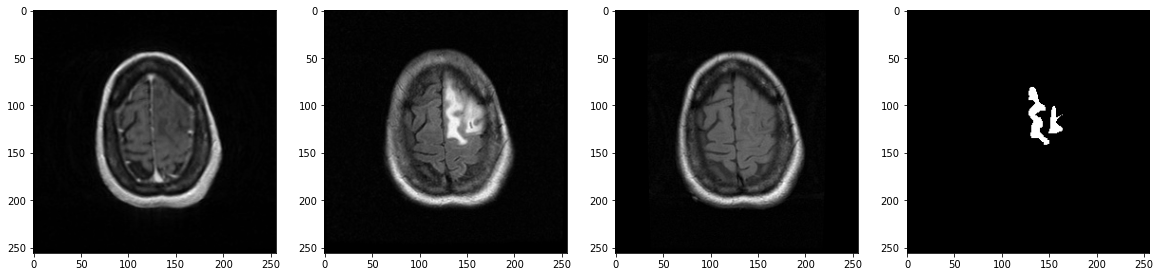

In [6]:
# show channelwise image 
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[:,:,i], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(mask)
plt.show()

In [7]:
img.shape, mask.shape

((256, 256, 3), (256, 256, 3))

(array([194169.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2439.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

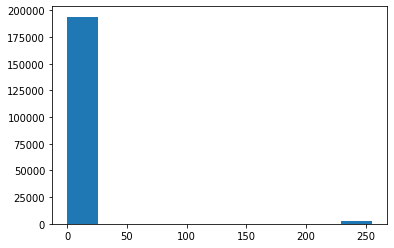

In [10]:
plt.hist(mask.ravel())

#### Data processing

In [8]:
IMG_SIZE = 256
BS = 64

In [11]:
class DataGenerator(utils.Sequence):
    def __init__(self, folder_path, batch_size, img_size, shuffle=True, aug=False):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])

        self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
        self.img_paths = [p.replace('_mask', '') for p in self.mask_paths]
        self.indexes = np.arange(len(self.mask_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)
            # img and mask preprocess
            img = self.preprocess(img)
            mask = self.preprocess(mask)
            x[i] = img
            y[i] = mask[:,:,:1]
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y
    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [12]:
train_gen = DataGenerator('brain-mri-seg/train', BS, IMG_SIZE, aug=True)
test_gen = DataGenerator('brain-mri-seg/test', BS, IMG_SIZE, aug=False)

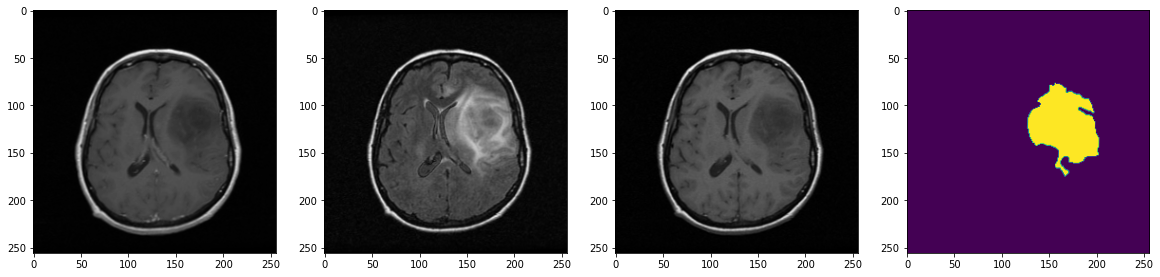

In [15]:
# Check output

batch_x, batch_y = train_gen[0]

for batch_i in range(1):
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1,4,i+1)
        plt.imshow(batch_x[batch_i, :,:,i], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(batch_y[batch_i, :,:, 0])
    plt.show()

#### Build model

In [ ]:
# Method 1: Enlarge feature maps by UpSampling2D
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D(strides=(2,2))(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = layers.concatenate([layers.UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

In [16]:
# Method 2: Enlarge feature maps by Conv2DTranspose
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D(strides=(2,2))(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(c4), 
                        c3], 
                       axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(l), 
                        c2], 
                       axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(l), 
                        c1], 
                       axis=-1)
l = layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

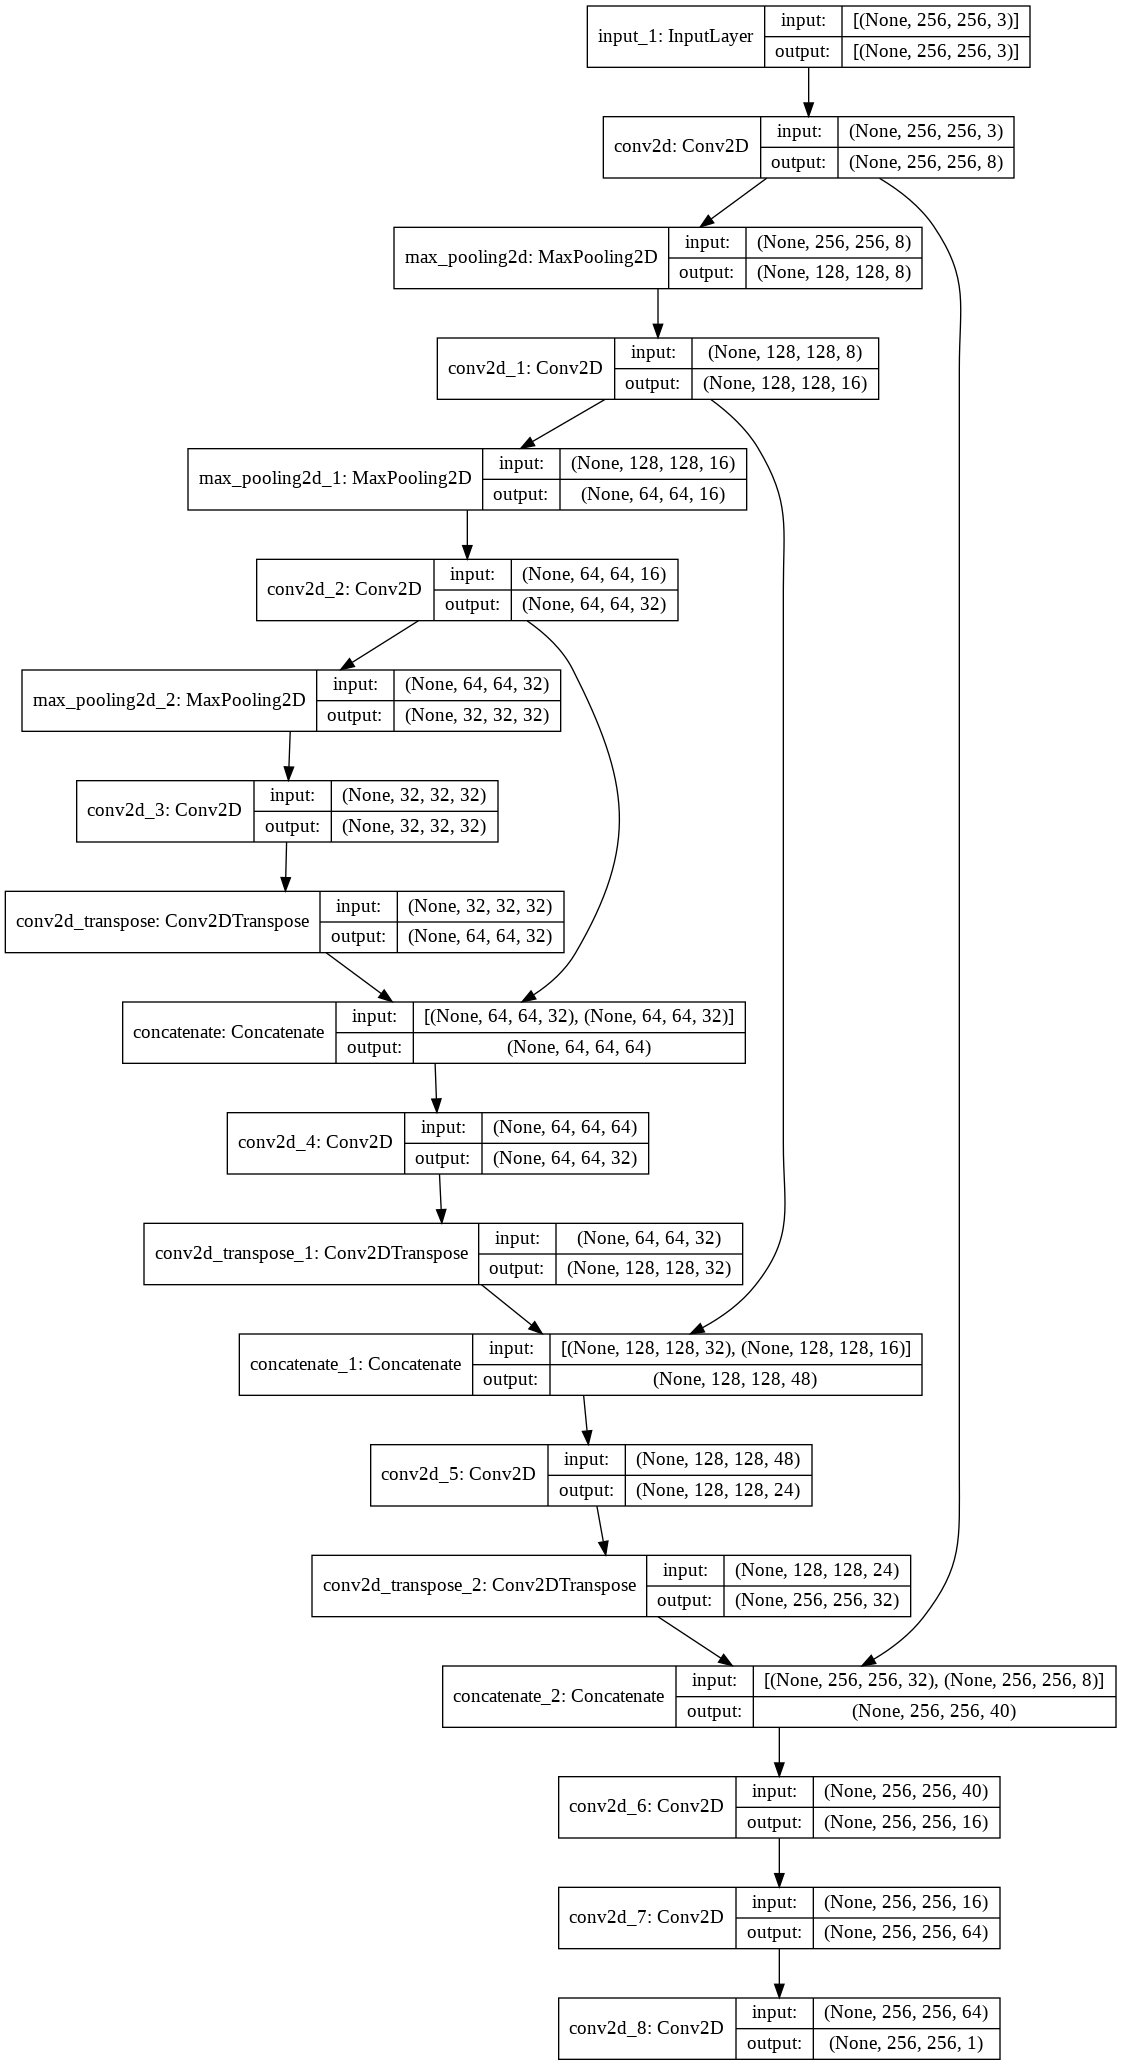

In [17]:
utils.plot_model(model, show_shapes=True)

#### Training

In [18]:
# Customize Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [19]:
model.compile(optimizer=optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=[dice_coef])

In [20]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
logs = model.fit(train_gen,
                 validation_data = test_gen,
                 epochs=100,
                 callbacks = [weight_saver, earlystop])

Epoch 1/100
18/18 [==============================] - 56s 1s/step - loss: 0.6119 - dice_coef: 0.0490 - val_loss: 0.3632 - val_dice_coef: 0.0223
Epoch 2/100
18/18 [==============================] - 19s 1s/step - loss: 0.2584 - dice_coef: 0.0088 - val_loss: 0.1675 - val_dice_coef: 0.0210
Epoch 3/100
18/18 [==============================] - 19s 1s/step - loss: 0.1147 - dice_coef: 0.0582 - val_loss: 0.1010 - val_dice_coef: 0.1116
Epoch 4/100
18/18 [==============================] - 19s 1s/step - loss: 0.0868 - dice_coef: 0.1388 - val_loss: 0.0907 - val_dice_coef: 0.1607
Epoch 5/100
18/18 [==============================] - 19s 1s/step - loss: 0.0792 - dice_coef: 0.1789 - val_loss: 0.0836 - val_dice_coef: 0.2082
Epoch 6/100
18/18 [==============================] - 19s 1s/step - loss: 0.0734 - dice_coef: 0.2165 - val_loss: 0.0771 - val_dice_coef: 0.2360
Epoch 7/100
18/18 [==============================] - 19s 1s/step - loss: 0.0682 - dice_coef: 0.2620 - val_loss: 0.0761 - val_dice_coef: 0.2760

#### Evaluate

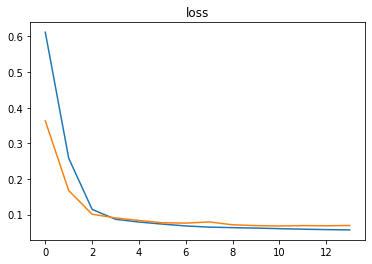

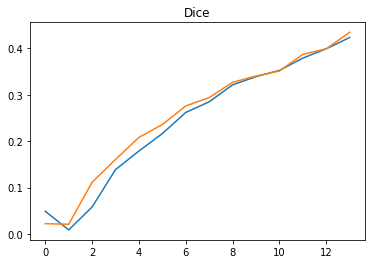

In [22]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [23]:
model_final = models.load_model('seg.h5', compile=False)

2


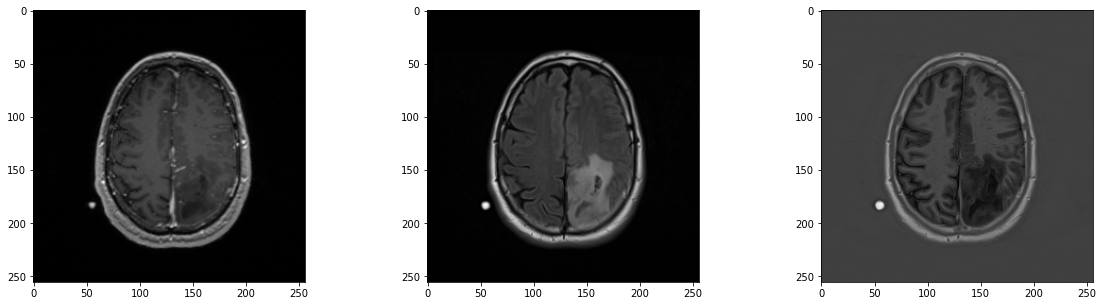

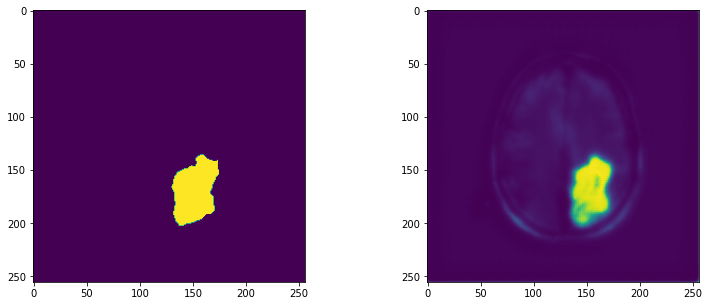

In [24]:
# Sample 1 batch
batch_idx = np.random.randint(len(test_gen))
print(batch_idx)
data = test_gen[batch_idx]
imgs, mask = data # (bs, 256, 256, 3), (bs, 256, 256, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(imgs[img_idx, :,:, i], cmap='gray')
plt.show()

# show ground truth & model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [25]:
# Displayed by different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[0.12642896, 0.06103322, 0.04976515, ..., 0.06406225, 0.07542548,
        0.20763774],
       [0.06253114, 0.02300667, 0.01599057, ..., 0.01597004, 0.02753925,
        0.10865192],
       [0.04624522, 0.01584537, 0.00944461, ..., 0.01085648, 0.01790872,
        0.08852174],
       ...,
       [0.06112642, 0.01910519, 0.00930154, ..., 0.01071338, 0.01988408,
        0.11165812],
       [0.07006339, 0.02960458, 0.01571267, ..., 0.02920682, 0.05566645,
        0.1517717 ],
       [0.17031884, 0.07695442, 0.06463075, ..., 0.09911824, 0.13738616,
        0.31700483]], dtype=float32)

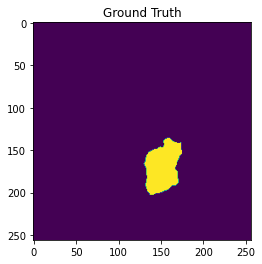

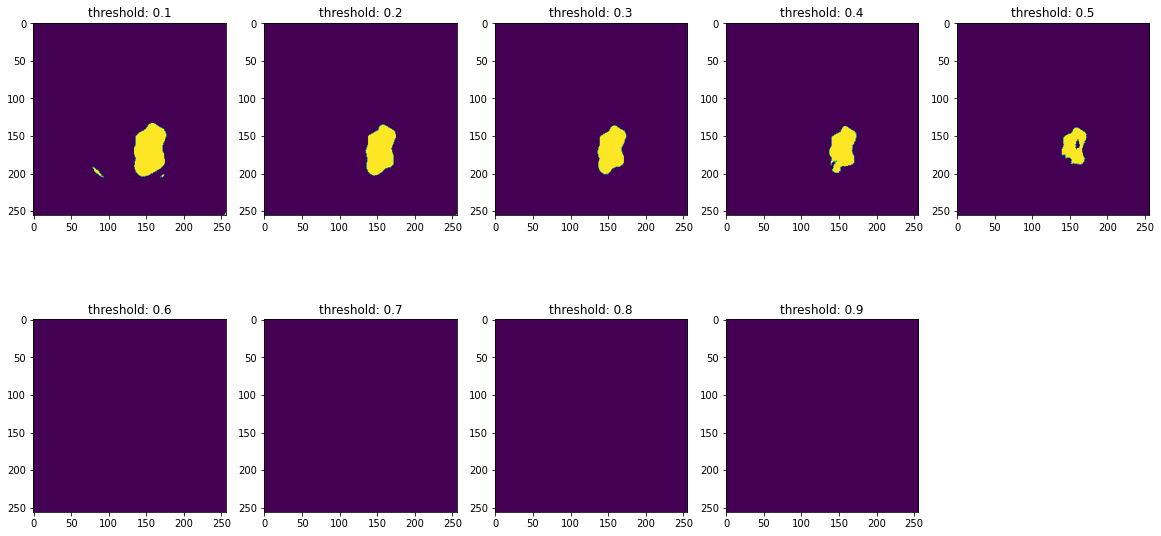

In [26]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()